In [15]:
#importing
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import keras
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [16]:
MLP_distances_all_data = []

/home/ni/Downloads/Geant4 Data/output_nt_Hits_1mm.csv
Average MLP Distance (mm): 0.015059249162057906
Median MLP Distance (mm): 0.0


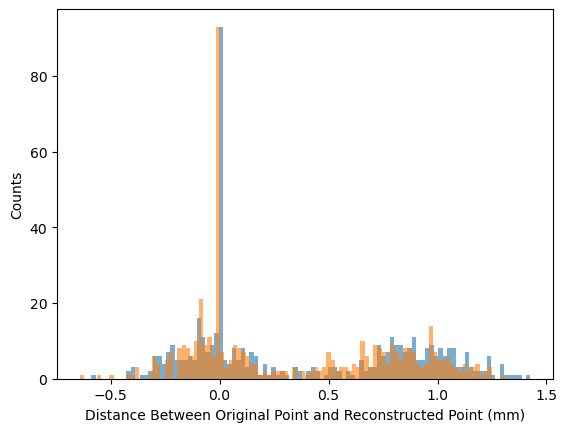

/home/ni/Downloads/Geant4 Data/output_nt_Hits_2mm.csv
Average MLP Distance (mm): 0.003946192244461008
Median MLP Distance (mm): 0.0


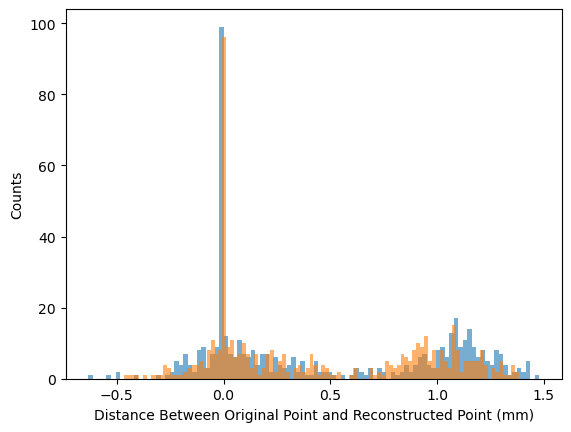

/home/ni/Downloads/Geant4 Data/output_nt_Hits_3mm.csv


In [ ]:
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for q in numbers:
    #getting X data
    #file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
    file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_' + str(q) + 'mm.csv')
    print('/home/ni/Downloads/Geant4 Data/output_nt_Hits_' + str(q) + 'mm.csv')
    csvreader = csv.reader(file)
    #first 13 rows aren't needed
    line_count = 0;
    original_X = []
    for row in csvreader:
      if line_count >= 13:
        original_X.append([int(i) for i in row])
      line_count += 1
    
    
    #getting Y data
    original_y = []
    for i in range(-122, 1):
      for j in range(-122, 1):
        original_y.append([i*0.2, j*0.2])
    
    #reconstructing
    size = 100
    num_X = np.array(original_X).reshape(123,123,9)
    num_y = np.array(original_y).reshape(123,123,2)
    num_X = num_X[122-size:,122-size:,:]
    num_y = num_y[122-size:,122-size:,:]
    bottom_right_X = []
    bottom_right_y = []
    for i in range(-size, 0):
      for j in range(-size, 1):
        tmp_X = copy.deepcopy(num_X[i+size][j+size])
        tmp_y = copy.deepcopy(num_y[i+size][j+size])
        #mirroring
        tmp_y[0] = -tmp_y[0]
        for k in range(3):
          tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
        bottom_right_X.append(tmp_X)
        bottom_right_y.append(tmp_y)
    
    bottom_right_X = np.array(bottom_right_X).reshape(size,size+1,9)
    bottom_right_y = np.array(bottom_right_y).reshape(size,size+1,2)
    
    top_left_X = []
    top_left_y = []
    for i in range(-size, 1):
      for j in range(-size, 0):
        tmp_X = copy.deepcopy(num_X[i+size][j+size])
        tmp_y = copy.deepcopy(num_y[i+size][j+size])
        #mirroring
        tmp_y[1] = -tmp_y[1]
        for k in range(3):
          tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
        top_left_X.append(tmp_X)
        top_left_y.append(tmp_y)
    
    top_left_X = np.array(top_left_X).reshape(size+1,size,9)
    top_left_y = np.array(top_left_y).reshape(size+1,size,2)
    
    top_right_X = []
    top_right_y = []
    for i in range(-size, 0):
      for j in range(-size, 0):
        tmp_X = copy.deepcopy(top_left_X[i+size][j+size])
        tmp_y = copy.deepcopy(top_left_y[i+size][j+size])
        #mirroring
        tmp_y[0] = -tmp_y[0]
        for k in range(3):
          tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
        top_right_X.append(tmp_X)
        top_right_y.append(tmp_y)
    
    top_right_X = np.array(top_right_X).reshape(size,size,9)
    top_right_y = np.array(top_right_y).reshape(size,size,2)
    
    #converting to numpy array
    X = np.concatenate((num_X.reshape((size + 1) * (size + 1), 9), bottom_right_X.reshape(size * (size + 1), 9), top_left_X.reshape(size * (size + 1), 9), top_right_X.reshape(size * size, 9)))
    y = np.concatenate((num_y.reshape((size + 1) * (size + 1), 2), bottom_right_y.reshape(size * (size + 1), 2), top_left_y.reshape(size * (size + 1), 2), top_right_y.reshape(size * size, 2)))
    
    #training
    MLP_distances = np.zeros((245,245,2))
    scaler = StandardScaler()
    for k in range(10):
        X_MLP = scaler.fit_transform(X)
        X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)
    
        model = Sequential()
        model.add(Dense(128, input_dim=9, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(2, activation='linear'))
    
        model.compile(optimizer='adam', loss='mean_squared_error')
     
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
        #finding distances
        yhat = model.predict(X_MLP)
        for i in range(len(X)):
            #finding average of each point
            MLP_distances[size+round(y[i][0]*5)][size-round(y[i][1]*5)][0] = k / (k + 1) * MLP_distances[size+round(y[i][0]*5)][size-round(y[i][1]*5)][0] + 1 / (k + 1) * (yhat[i][0] - y[i][0])
            MLP_distances[size+round(y[i][0]*5)][size-round(y[i][1]*5)][1] = k / (k + 1) * MLP_distances[size+round(y[i][0]*5)][size-round(y[i][1]*5)][1] + 1 / (k + 1) * (yhat[i][1] - y[i][1])
    
    print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
    print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

    plt.hist(MLP_distances[:][:][0].ravel(), bins=100, alpha=0.6, label='delta X')
    plt.hist(MLP_distances[:][:][1].ravel(), bins=100, alpha=0.6, label='delta Y')
    plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
    plt.ylabel('Counts')
    plt.show()

    MLP_distances_all_data.append(MLP_distances)

In [ ]:
MLP_distances_all_data_np = np.array(MLP_distances_all_data)
np.savetxt('MLP_distances_delta_cut.csv', MLP_distances_all_data_np.reshape(MLP_distances_all_data_np.shape[0], -1))

#print(MLP_distances_all_data_np.shape)